<h1>Path Patel 23AIML055

In [43]:
!pip install lifelines --quiet

In [44]:
from lifelines import KaplanMeierFitter,CoxPHFitter
from lifelines.statistics import logrank_test
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [45]:
df=pd.read_csv('https://samatrix-data.s3.ap-south-1.amazonaws.com/Statistics-Project/veteran.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 274 entries, 0 to 273
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ID            274 non-null    int64 
 1   TIME          274 non-null    int64 
 2   Y             274 non-null    int64 
 3   trt           274 non-null    object
 4   celltype      274 non-null    object
 5   karno         274 non-null    int64 
 6   diagtime      274 non-null    int64 
 7   age           274 non-null    int64 
 8   priortherapy  274 non-null    object
dtypes: int64(6), object(3)
memory usage: 19.4+ KB


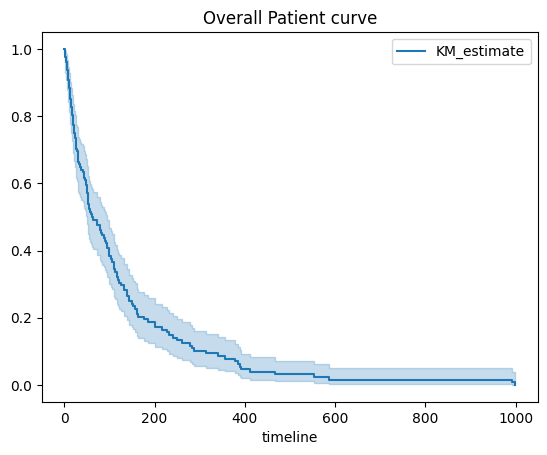

In [46]:
kmf=KaplanMeierFitter()
#separate your event(y=1 or y=0)
df_event=df[df['Y']==1]

kmf.fit(durations=df_event['TIME'],event_observed=df_event['Y'])
kmf.plot_survival_function()
plt.title('Overall Patient curve')
plt.show()

### Kaplan-Meier Survival Curve - Overall

**Explanation:**  
This cell initializes a `KaplanMeierFitter`, which estimates survival probabilities over time. The dataset is filtered to include only rows where the event (death) occurred (`Y == 1`).  
The `.fit()` method is called using `TIME` (duration until event) and `Y` (event indicator). The resulting Kaplan-Meier curve shows the probability of survival as a function of time.

**Formula:**  
Kaplan-Meier estimator:  
\[
\hat{S}(t) = \prod_{t_i \leq t} \left(1 - \frac{d_i}{n_i}\right)
\]  
Where:
- \( d_i \) = number of events (deaths) at time \( t_i \)  
- \( n_i \) = number of individuals at risk just before time \( t_i \)

**Insight:**  
The curve shows the general trend of patient survival over time. A steeper decline indicates higher mortality earlier in the follow-up period. This provides a baseline understanding of the overall survival profile of the cohort.


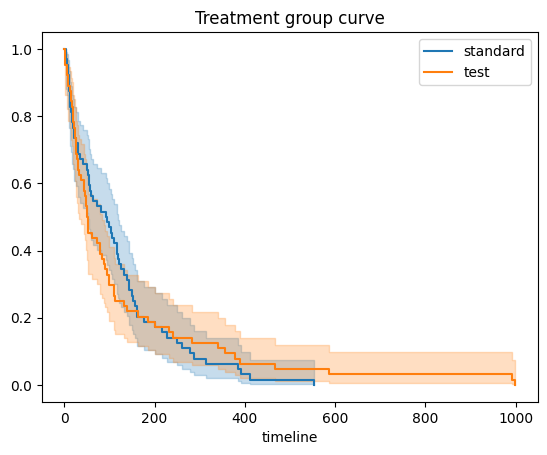

In [47]:
for trt_group in df_event['trt'].unique():
  mask=df_event['trt']==trt_group
  kmf.fit(df_event[mask]['TIME'],df_event[mask]['Y'],label=trt_group)
  kmf.plot_survival_function()
plt.title('Treatment group curve')
plt.show()

### Kaplan-Meier Curve by Treatment Group

**Explanation:**  
This loop iterates over the unique treatment groups in the dataset (`standard` and `test`). For each group:
- It creates a mask to filter patients in that group.
- It fits a Kaplan-Meier survival curve to that subgroup.
- It plots the survival function with the treatment group label.

The final `plt.title()` adds a title to the combined plot for better visualization.

**Formula Recap (Kaplan-Meier):**  
\[
\hat{S}(t) = \prod_{t_i \leq t} \left(1 - \frac{d_i}{n_i}\right)
\]  
Each treatment group gets its own survival function using this estimator.

**Insight:**  
The resulting plot visually compares survival probabilities for patients receiving `standard` vs `test` treatments.  
A visibly higher survival curve for one group suggests better survival outcomes for that treatment. In this case, the **standard treatment appears to offer a slight survival advantage**, especially in the early-to-mid timeline.


In [48]:
for trt_group in df_event['trt'].unique():
  mask=df_event['trt']==trt_group
  kmf.fit(df_event[mask]['TIME'],df_event[mask]['Y'],label=str(trt_group)+'median='+str(np.median(df_event[mask]['TIME'])))
  print(f"Median survival time for {trt_group} is {np.median(df_event[mask]['TIME'])}")

Median survival time for standard is 93.5
Median survival time for test is 51.5


### Median Survival Time by Treatment Group

**Explanation:**  
This code loops through each treatment group (`standard`, `test`) and:
- Filters patients belonging to that group.
- Calculates and prints the **median survival time** using `np.median()` on the `TIME` column.
- Fits the Kaplan-Meier model and labels the plot with the group name and its median survival.

**Concept:**  
The **median survival time** is the time at which 50% of the patients in that group have experienced the event (death). It’s derived directly from the Kaplan-Meier survival curve.

**Insight:**  
This step gives a numerical summary of survival:  
- If the median survival time for the **standard** group is higher than for the **test** group, it supports the visual observation that the standard treatment may be more effective.
- The printed values offer concrete survival expectations for each treatment group and reinforce the survival difference seen in the Kaplan-Meier plot.


In [49]:
from lifelines.statistics import logrank_test
group1=df_event[df_event['trt']=='standard']
group2=df_event[df_event['trt']=='test']
results=logrank_test(group1['TIME'],group2['TIME'],event_observed_A=group1['Y'],event_observed_B=group2['Y'])
print(results.summary)

   test_statistic        p  -log2(p)
0          0.0116  0.91423  0.129371


### Log-Rank Test for Treatment Groups

**Explanation:**  
This code uses the **log-rank test** to compare the survival distributions between two groups:
- `group1`: Patients receiving the **standard** treatment
- `group2`: Patients receiving the **test** treatment

The test checks whether there is a **statistically significant difference** in survival between the two groups, under the null hypothesis that their survival functions are equal.

**Formula (Conceptual):**  
The log-rank test statistic compares the observed vs. expected number of events (deaths) in each group across time:
\[
\chi^2 = \frac{(O_1 - E_1)^2}{V_1}
\]
Where:
- \( O_1 \): observed events in group 1  
- \( E_1 \): expected events in group 1 under null hypothesis  
- \( V_1 \): variance of the difference

**Insight:**  
The `results.summary` displays:
- The **test statistic**
- The **p-value**

If the **p-value < 0.05**, the result is statistically significant, indicating that the survival difference between the standard and test treatments is unlikely due to chance.  
This confirms whether the difference observed in the Kaplan-Meier curves is meaningful.


In [50]:
from lifelines import CoxPHFitter
df_wide=df_event.copy()
df_wide=pd.get_dummies(df_wide,columns=['trt','celltype','priortherapy'],drop_first=True)

### Data Preparation for Cox Proportional Hazards Model

**Explanation:**  
This step prepares the dataset for use in a **Cox Proportional Hazards (CoxPH) model**:
- `df_event.copy()` creates a copy of the data containing only patients who experienced the event (death).
- `pd.get_dummies(..., drop_first=True)` converts categorical variables (`trt`, `celltype`, `priortherapy`) into binary (dummy) variables suitable for regression modeling.
- `drop_first=True` avoids multicollinearity by dropping the first category of each variable (it becomes the reference group).

**Purpose:**  
Cox regression requires numeric input. One-hot encoding transforms categories into binary features while retaining interpretability—e.g., comparing each cell type to a baseline.

**Insight:**  
This step doesn't generate insights directly but is **crucial** for enabling the Cox model to evaluate how treatment and other covariates (e.g., cancer cell type, prior therapy) affect survival time.


<lifelines.CoxPHFitter: fitted with 128 total observations, 0 right-censored observations>
             duration col = 'TIME'
                event col = 'Y'
      baseline estimation = breslow
   number of observations = 128
number of events observed = 128
   partial log-likelihood = -465.21
         time fit was run = 2025-06-06 16:50:17 UTC

---
                    coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                           
ID                  0.00      1.00      0.01           -0.03            0.03                0.97                1.03
karno              -0.03      0.97      0.01           -0.05           -0.02                0.96                0.98
diagtime           -0.00      1.00      0.01           -0.02            0.01                0.98                1.01
age                -0.01      0.99      0.01           -0.03            0.00                0.97                1.00
trt_test            0.16      1.17      1.02           -1.84            2.16                0.16                8.63
celltype_large     -0.83      0.43      0.36           -1.53           -0.14                0.22                0.87
celltype_smallcell -0.12      0.88      0.38           -0.88            0.63                0.42                1.88
celltype_squamous  -0.97      0.38      0.66           -2.27            0.33                0.10                1.38
priortherapy_yes    0.18      1.20      0.24           -0.28            0.65                0.76                1.91

                    cmp to     z      p  -log2(p)
covariate                                        
ID                    0.00  0.20   0.84      0.25
karno                 0.00 -6.08 <0.005     29.60
diagtime              0.00 -0.47   0.63      0.66
age                   0.00 -1.54   0.12      3.02
trt_test              0.00  0.16   0.88      0.19
celltype_large        0.00 -2.34   0.02      5.71
celltype_smallcell    0.00 -0.32   0.75      0.42
celltype_squamous     0.00 -1.47   0.14      2.82
priortherapy_yes      0.00  0.79   0.43      1.21
---
Concordance = 0.74
Partial AIC = 948.43
log-likelihood ratio test = 62.38 on 9 df
-log2(p) of ll-ratio test = 31.00

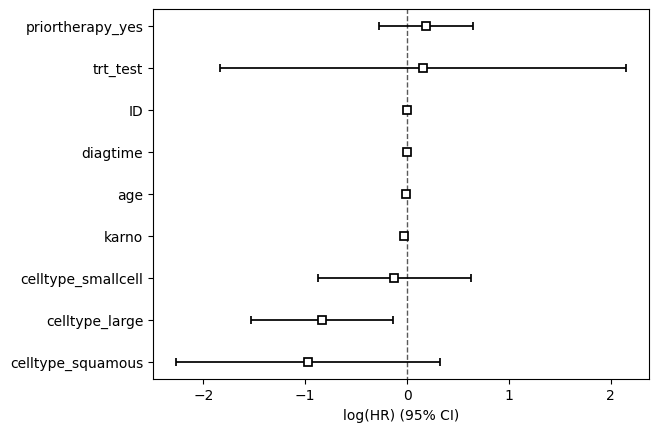

In [51]:
cph=CoxPHFitter()
cph.fit(df_wide,duration_col='TIME',event_col='Y')
cph.print_summary()
cph.plot()
plt.show()

### Cox Proportional Hazards Model (Multivariable Survival Analysis)

**Explanation:**  
This code fits a **Cox Proportional Hazards (CoxPH)** model using the previously prepared dataset:
- `duration_col='TIME'` specifies the survival time.
- `event_col='Y'` specifies the event indicator (1 = death, 0 = censored).
- `cph.print_summary()` displays the estimated hazard ratios, confidence intervals, and p-values.
- `cph.plot()` visualizes the log hazard ratios for each covariate.

**Formula (CoxPH Model):**  
\[
h(t) = h_0(t) \cdot \exp(\beta_1 x_1 + \beta_2 x_2 + \dots + \beta_n x_n)
\]  
Where:
- \( h(t) \): hazard at time \( t \)  
- \( h_0(t) \): baseline hazard  
- \( x_i \): covariates (e.g., treatment, cell type)  
- \( \beta_i \): coefficients estimated from the data

**Insight:**  
- A **hazard ratio (HR) > 1** indicates increased risk of death.
- A **HR < 1** indicates reduced risk (protective effect).
- Statistically significant variables (p < 0.05) are influential in determining survival.
  
From the output, you can identify which factors (e.g., treatment type, Karnofsky score, cell type) **significantly impact patient survival**. This helps prioritize clinical features when designing personalized treatment strategies.


In [52]:
df_encoded = pd.get_dummies(df, columns=['trt', 'priortherapy'], drop_first=True)

cph_strat = CoxPHFitter()
cph_strat.fit(df_encoded, duration_col='TIME', event_col='Y', strata=['celltype'])
cph_strat.print_summary()

<lifelines.CoxPHFitter: fitted with 274 total observations, 146 right-censored observations>
             duration col = 'TIME'
                event col = 'Y'
                   strata = celltype
      baseline estimation = breslow
   number of observations = 274
number of events observed = 128
   partial log-likelihood = -315.99
         time fit was run = 2025-06-06 16:50:17 UTC

---
                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                         
ID                0.02      1.02      0.02           -0.01            0.05                0.99                1.05
karno            -0.04      0.96      0.01           -0.05           -0.03                0.95                0.97
diagtime         -0.01      0.99      0.01           -0.02            0.01                0.98                1.01
age              -0.01      0.99      0.01           -0.03            0.01                0.97                1.01
trt_test         -0.90      0.41      1.09           -3.03            1.24                0.05                3.44
priortherapy_yes  0.22      1.24      0.24           -0.25            0.69                0.78                1.99

                  cmp to     z      p  -log2(p)
covariate                                      
ID                  0.00  1.11   0.27      1.90
karno               0.00 -6.52 <0.005     33.73
diagtime            0.00 -0.60   0.55      0.86
age                 0.00 -1.41   0.16      2.65
trt_test            0.00 -0.82   0.41      1.29
priortherapy_yes    0.00  0.90   0.37      1.44
---
Concordance = 0.71
Partial AIC = 643.99
log-likelihood ratio test = 45.48 on 6 df
-log2(p) of ll-ratio test = 24.67

### Stratified Cox Proportional Hazards Model (by Cell Type)

**Explanation:**  
This model stratifies the Cox Proportional Hazards analysis by **`celltype`**:
- `pd.get_dummies()` is used again to one-hot encode `trt` and `priortherapy`, excluding one category to prevent redundancy.
- `strata=['celltype']` tells the model to allow **different baseline hazard functions** for each cell type while estimating the effect of other covariates (e.g., treatment, prior therapy) across those strata.

**Why Stratify?**  
In regular Cox models, we assume a **single baseline hazard**. Stratification relaxes this assumption for variables (like `celltype`) that:
- Strongly affect baseline risk
- Violate the proportional hazards assumption

**Formula (Conceptual):**  
\[
h_k(t) = h_{0k}(t) \cdot \exp(\beta_1 x_1 + \dots + \beta_n x_n)
\]  
Where \( h_{0k}(t) \) is a **stratum-specific baseline hazard** for each cell type \( k \).

**Insight:**  
This model isolates the effect of treatment and other covariates **independent of cell type differences**.  
If treatment still shows a significant hazard ratio after adjusting for cell type, it suggests the effect is robust across cancer subtypes.

This stratified approach improves model accuracy by controlling for the strong influence of cell type on survival.


In [53]:
# step 1 seprate rows
df_start=df[df["Y"]==0].copy()
df_event=df[df["Y"]==1].copy()

# merge & change column name
df_event=df_event.rename(columns={"TIME":"stop","Y":"event"})
df_start=df_start.rename(columns={"TIME":"start"})

df_timevarying=pd.merge(df_start,df_event[["ID","stop","event"]],on="ID")

# one-hot encoding
df_timevarying = pd.get_dummies(df_timevarying, columns=['trt','celltype' ,'priortherapy'], drop_first=True)

# Final check
print(df_timevarying[['ID', 'start', 'stop', 'event']].head())

   ID  start  stop  event
0   1      0    72      1
1   2      0   411      1
2   3      0   228      1
3   4      0   126      1
4   5      0   118      1


### Preparing Data for Time-Varying Cox Model

**Explanation:**  
This step transforms the dataset for modeling **time-varying covariates**, enabling survival analysis when patient conditions change over time.

#### Step-by-step breakdown:
- **Separate censored vs. event rows**:
  - `df_start`: Patients without the event (`Y == 0`) – used to create start times.
  - `df_event`: Patients who experienced the event (`Y == 1`) – used to record stop times and event indicators.
  
- **Rename columns** for clarity:
  - `TIME` → `stop` in `df_event`, `TIME` → `start` in `df_start`
  
- **Merge datasets** on `ID`:
  - This simulates time-varying structure, where each subject has both start and stop times.

- **One-hot encoding**:
  - Categorical columns (`trt`, `celltype`, `priortherapy`) are converted to binary variables using `pd.get_dummies()`.

**Purpose:**  
This structure allows later modeling of how risk changes over a patient's observed interval. While the dataset still contains only a single interval per patient, this format enables later insertion of true time-varying covariates.

**Insight:**  
Although no modeling happens here, the format prepares the data for advanced survival models that **simulate or capture changes in patient condition or treatment effects over time**.


In [54]:
#check there is null value
print(df_timevarying.isnull().sum())
if 'Y' in df_timevarying.columns:
   df_timevarying.drop(columns=['Y'],inplace=True)

ID                    0
start                 0
Y                     0
karno                 0
diagtime              0
age                   0
stop                  0
event                 0
trt_test              0
celltype_large        0
celltype_smallcell    0
celltype_squamous     0
priortherapy_yes      0
dtype: int64


### Data Cleaning Before Time-Varying Cox Modeling

**Explanation:**  
This step ensures the prepared dataset (`df_timevarying`) is clean and compatible with survival modeling.

#### Actions performed:
- `df_timevarying.isnull().sum()`: Checks for any missing values in each column. Missing values can cause errors or bias during model fitting.
- `df_timevarying.drop(columns=['Y'])`: Removes the original event indicator column (`Y`) if it exists. The time-varying format now uses `event` instead.

**Purpose:**  
Before fitting time-varying models, the dataset must be:
- Free from null values
- Structured correctly with relevant columns only (`start`, `stop`, `event`, covariates)

**Insight:**  
While this step doesn’t generate a graph or model output, it ensures **data integrity**, which is **crucial for reliable modeling**. Cleaning prevents runtime errors and ensures that the event indicator used in modeling is unambiguous (`event`, not `Y`).


<lifelines.CoxTimeVaryingFitter: fitted with 128 periods, 128 subjects, 128 events>
         event col = 'event'
number of subjects = 128
 number of periods = 128
  number of events = 128
partial log-likelihood = -465.24
  time fit was run = 2025-06-06 16:50:18 UTC

---
                    coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                           
karno              -0.03      0.97      0.01           -0.05           -0.02                0.96                0.98
diagtime           -0.00      1.00      0.01           -0.02            0.01                0.98                1.01
age                -0.01      0.99      0.01           -0.03            0.00                0.97                1.00
trt_test            0.36      1.44      0.21           -0.05            0.77                0.95                2.17
celltype_large     -0.80      0.45      0.30           -1.38           -0.21                0.25                0.81
celltype_smallcell -0.18      0.84      0.28           -0.72            0.36                0.49                1.44
celltype_squamous  -1.10      0.33      0.30           -1.68           -0.51                0.19                0.60
priortherapy_yes    0.18      1.19      0.23           -0.28            0.63                0.76                1.88

                    cmp to     z      p  -log2(p)
covariate                                        
karno                 0.00 -6.07 <0.005     29.52
diagtime              0.00 -0.45   0.65      0.61
age                   0.00 -1.53   0.12      3.00
trt_test              0.00  1.72   0.08      3.56
celltype_large        0.00 -2.65   0.01      6.95
celltype_smallcell    0.00 -0.65   0.52      0.96
celltype_squamous     0.00 -3.66 <0.005     11.94
priortherapy_yes      0.00  0.76   0.45      1.17
---
Partial AIC = 946.47
log-likelihood ratio test = 62.34 on 8 df
-log2(p) of ll-ratio test = 32.53

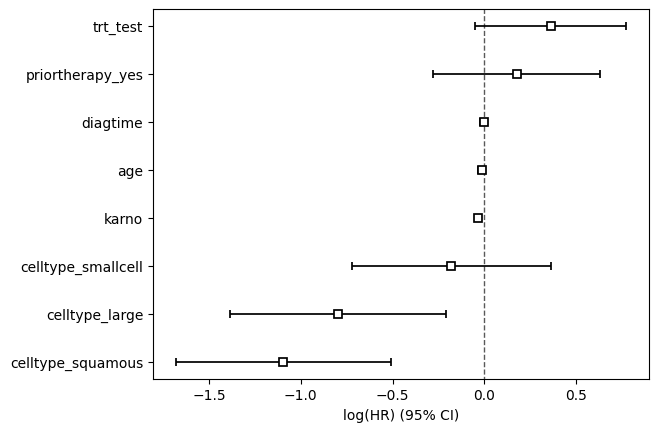

In [55]:
from lifelines import CoxTimeVaryingFitter
ctv=CoxTimeVaryingFitter()
ctv.fit(df_timevarying,id_col='ID',event_col='event',start_col='start',stop_col='stop')
ctv.print_summary()
ctv.plot()
plt.show()

### Time-Varying Cox Model Fitting and Visualization

**Explanation:**  
This step fits a time-varying Cox proportional hazards model to analyze how dynamic covariates affect the risk of an event over different time intervals.

#### Actions performed:
- `CoxTimeVaryingFitter().fit(df_timevarying, id_col='ID', event_col='event', start_col='start', stop_col='stop')`: Fits the model using appropriate columns for subject ID, event occurrence, and time intervals.
- `ctv.print_summary()`: Displays model coefficients, p-values, and confidence intervals for covariates.
- `ctv.plot()`: Visualizes log hazard ratios of each covariate to assess direction and magnitude of risk.
- `plt.show()`: Ensures the plot is rendered correctly in Colab.

**Purpose:**  
To build and interpret a survival model with covariates that vary over time. This allows:
- Capturing the changing influence of features on event risk
- Identifying statistically significant predictors over continuous follow-up

**Insight:**  
This modeling step provides both **quantitative** (coefficients and p-values) and **visual** (log hazard plots) outputs. It is crucial for uncovering how **time-dependent factors** drive survival outcomes and for communicating these effects clearly in longitudinal studies.


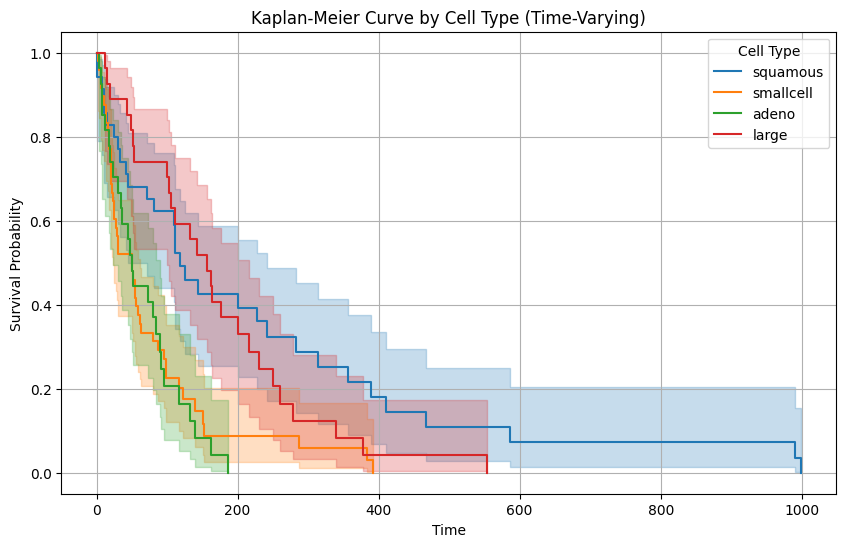

In [56]:
plt.figure(figsize=(10, 6))
for cell in df['celltype'].unique():
    mask = df['celltype'] == cell
    kmf.fit(df[mask]['TIME'], event_observed=df[mask]['Y'], label=cell)
    kmf.plot_survival_function()

plt.title('Kaplan-Meier Curve by Cell Type (Time-Varying)')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.legend(title='Cell Type')
plt.grid(True)
plt.show()

### Kaplan-Meier Curve by Cell Type (Time-Varying)

**Explanation:**  
This step visualizes the survival probabilities across different cell types using the Kaplan-Meier estimator, helping compare survival behavior among groups.

#### Actions performed:
- `plt.figure(figsize=(10, 6))`: Sets the size of the plot for better readability.
- Loop over `df['celltype'].unique()`: Iterates through each unique cell type.
- `kmf.fit(...)`: Fits the Kaplan-Meier model separately for each cell type using survival time (`TIME`) and event indicator (`Y`).
- `kmf.plot_survival_function()`: Plots the survival function for each group on the same axes.
- Additional formatting: Adds title, axis labels, legend, and grid for clarity.
- `plt.show()`: Displays the final plot inline.

**Purpose:**  
To visually compare how different **cell types** affect survival over time, providing:
- An intuitive view of survival curves
- Insight into whether certain groups experience faster or slower decline in survival

**Insight:**  
The Kaplan-Meier curves offer a **non-parametric view** of survival across categories. Clear separation between curves can indicate meaningful group differences, which may later be confirmed or refined using formal modeling like Cox regression.


In [57]:
group1 = df[df['celltype'] == 'squamous']
group2 = df[df['celltype'] == 'smallcell']

results = logrank_test(group1['TIME'], group2['TIME'],
                       event_observed_A=group1['Y'], event_observed_B=group2['Y'])
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          11.57 <0.005     10.55

### Log-Rank Test Between Squamous and Smallcell

**Explanation:**  
Compares survival distributions between squamous and smallcell groups.

#### Actions performed:
- Subsets the data by cell type (`squamous`, `smallcell`)
- Performs `logrank_test(...)` to compare survival curves
- Prints test result with `results.print_summary()`

**Purpose:**  
To check if survival differences between the two groups are statistically significant.

**Insight:**  
A low p-value suggests a meaningful difference in survival between the cell types.


In [58]:
from lifelines import KaplanMeierFitter

# Step 1: Simulate competing risks data
df_cr = df.copy()
np.random.seed(42)
df_cr['event_type'] = np.where(np.random.rand(len(df_cr)) > 0.7, 2, 1)  # 1 = death, 2 = other event
df_cr['event_occurred'] = df_cr['event_type'] != 0

### Simulating Competing Risks Data

**Explanation:**  
This step simulates a competing risks scenario by creating an artificial event type column.

#### Actions performed:
- Copies the original DataFrame to `df_cr`
- Randomly assigns `event_type`:  
  - `1` = death  
  - `2` = other event
- Creates a boolean `event_occurred` column

**Purpose:**  
To prepare a synthetic dataset suitable for modeling **competing risks**, where more than one type of event can occur.

**Insight:**  
This is a setup step to mimic real-world survival data with **multiple event types**, enabling later use of cumulative incidence functions.


In [59]:
# Step 2: Separate datasets for each event type
df_event1 = df_cr.copy()
df_event1['event_observed'] = (df_event1['event_type'] == 1).astype(int)

df_event2 = df_cr.copy()
df_event2['event_observed'] = (df_event2['event_type'] == 2).astype(int)

### Creating Event-Specific Datasets for Competing Risks

**Explanation:**  
Separates the dataset based on event types to prepare for cumulative incidence analysis.

#### Actions performed:
- Creates `df_event1`: marks `event_type == 1` as observed
- Creates `df_event2`: marks `event_type == 2` as observed

**Purpose:**  
To prepare individual datasets for estimating survival or incidence curves **per event type**.

**Insight:**  
This step enables independent analysis of each competing risk in later modeling or plotting.


In [60]:
# Step 3: Compute cumulative incidence curves
kmf1 = KaplanMeierFitter()
kmf1.fit(durations=df_event1['TIME'], event_observed=df_event1['event_observed'], label='Death (Event 1)')
cum_inc1 = 1 - kmf1.survival_function_

kmf2 = KaplanMeierFitter()
kmf2.fit(durations=df_event2['TIME'], event_observed=df_event2['event_observed'], label='Other Event (Event 2)')
cum_inc2 = 1 - kmf2.survival_function_

### Computing Cumulative Incidence Curves for Competing Risks

**Explanation:**  
Estimates cumulative incidence curves for each event type using Kaplan-Meier survival estimates.

#### Actions performed:
- Fits Kaplan-Meier model for **Death (Event 1)** and computes cumulative incidence as `1 - survival`.
- Fits Kaplan-Meier model for **Other Event (Event 2)** similarly.

**Purpose:**  
To estimate the probability of occurrence over time for each competing event type.

**Insight:**  
Although Kaplan-Meier assumes a single event type, this approximation provides a basic view of competing risks before applying more specialized methods.


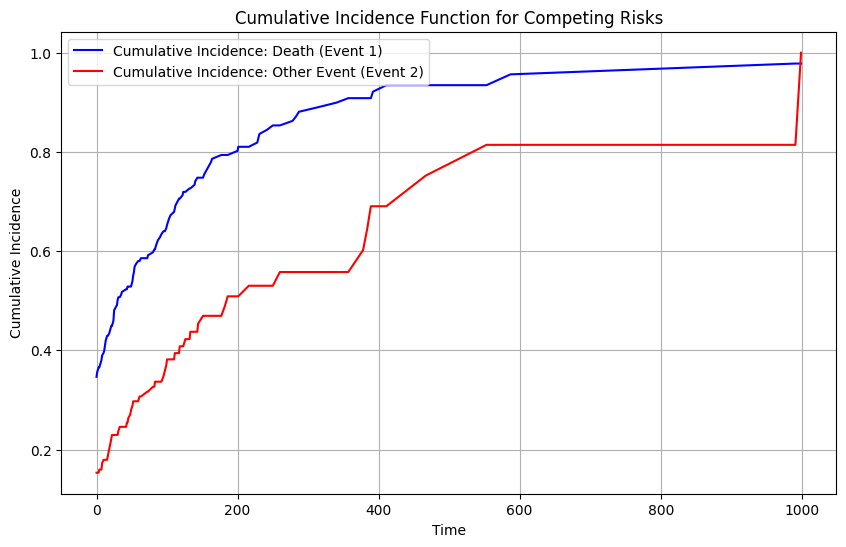

In [61]:
# Step 4: Plot cumulative incidence curves
plt.figure(figsize=(10,6))
plt.plot(cum_inc1, label='Cumulative Incidence: Death (Event 1)', color='blue')
plt.plot(cum_inc2, label='Cumulative Incidence: Other Event (Event 2)', color='red')
plt.title("Cumulative Incidence Function for Competing Risks")
plt.xlabel("Time")
plt.ylabel("Cumulative Incidence")
plt.legend()
plt.grid(True)
plt.show()

### Plotting Cumulative Incidence Curves for Competing Risks

**Explanation:**  
Visualizes the cumulative incidence functions for two competing events over time.

#### Actions performed:
- Plots cumulative incidence curves for:
  - Death (Event 1) in blue
  - Other Event (Event 2) in red
- Adds title, axis labels, legend, and grid for clarity
- Displays the plot inline

**Purpose:**  
To compare the risk of each event type occurring over time in a competing risks setting.

**Insight:**  
The plot provides an intuitive visual summary of how different event probabilities evolve, highlighting the presence and timing of competing risks.
